# **Introduction to Building Agents**

In this notebook we are going to first see how to build a basic agent.

Later we will use LangGraph to build powerful agents.

## **Step 1 - Initializing a Large Language Model**

In [1]:
from langchain_openai import ChatOpenAI

/Users/kanavbansal/Developer/.env_jupyter/lib/python3.9/site-packages/urllib3/__init__.py:35: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(


In [2]:
# Setup API Key

f = open('keys/.openai_api_key.txt')

OPENAI_API_KEY = f.read()

In [3]:
llm = ChatOpenAI(openai_api_key=OPENAI_API_KEY,
                 model="gpt-4o-mini",
                 temperature=0.0)

response = llm.invoke("What is the current time?")

print(response.content)

I don't have real-time capabilities to provide the current time. You can check the time on your device or through a search engine.


In [4]:
llm = ChatOpenAI(openai_api_key=OPENAI_API_KEY,
                 model="gpt-4o-mini",
                 temperature=0.0)

response = llm.invoke("Is Sunita William currently in space?")

print(response.content)

As of my last update in October 2023, I do not have real-time information about current space missions or the status of astronauts. To find out if Sunita Williams is currently in space, I recommend checking the latest updates from NASA or other reliable space news sources.


## **Step 2 - Initializing a Tool**

In [5]:
from langchain_core.tools import tool
from datetime import datetime

@tool
def current_datetime():
    """This function tells the current date and time."""
    current_datetime = datetime.now().strftime("%Y-%m-%d %H:%M:%S")
    return f"The current date and time is {current_datetime}"

current_datetime.invoke({})

'The current date and time is 2025-03-12 16:18:00'

## **Step 3 - Init an Agent (i.e. Binding the Tool with a LLM)**

In [6]:
llm_with_tool = llm.bind_tools([current_datetime])

llm_with_tool

RunnableBinding(bound=ChatOpenAI(client=<openai.resources.chat.completions.Completions object at 0x114e80dc0>, async_client=<openai.resources.chat.completions.AsyncCompletions object at 0x114e9f790>, root_client=<openai.OpenAI object at 0x111b200d0>, root_async_client=<openai.AsyncOpenAI object at 0x114e80df0>, model_name='gpt-4o-mini', temperature=0.0, model_kwargs={}, openai_api_key=SecretStr('**********')), kwargs={'tools': [{'type': 'function', 'function': {'name': 'current_datetime', 'description': 'This function tells the current date and time.', 'parameters': {'properties': {}, 'type': 'object'}}}]}, config={}, config_factories=[])

In [7]:
response = llm_with_tool.invoke("Hi")

print(f"Content: {response.content}")
print(f"Tool Call: {response.tool_calls}")

Content: Hello! How can I assist you today?
Tool Call: []


In [8]:
response.pretty_print()

================================== Ai Message ==================================

Hello! How can I assist you today?


In [9]:
response = llm_with_tool.invoke("What is the current date?")

print(f"Content: {response.content}")
print(f"Tool Call: {response.tool_calls}")

Content: 
Tool Call: [{'name': 'current_datetime', 'args': {}, 'id': 'call_saexBqPbsDMBRUxV1VFnQYZe', 'type': 'tool_call'}]


In [10]:
response.pretty_print()

================================== Ai Message ==================================
Tool Calls:
  current_datetime (call_saexBqPbsDMBRUxV1VFnQYZe)
 Call ID: call_saexBqPbsDMBRUxV1VFnQYZe
  Args:


## **Step 4 - Tool Call and Executing the Agent**

In [11]:
dict_with_tool_names = {
    "current_datetime": current_datetime,
}

def custom_agent_executor(response):
    if response.tool_calls:
        for tool_calls in response.tool_calls:
            tool_name = tool_calls["name"]
            tool_args = tool_calls["args"]
            tool_func = dict_with_tool_names[tool_name]
            return tool_func.invoke(tool_args)
    else:
        return response.content

In [12]:
custom_agent_executor(llm_with_tool.invoke("Hi"))

'Hello! How can I assist you today?'

In [13]:
custom_agent_executor(llm_with_tool.invoke("What is the time?"))

'The current date and time is 2025-03-12 16:18:14'

# **A Better Implementation**

## **Step 1 - Init a LLM**

In [14]:
from langchain_openai import ChatOpenAI

f = open('keys/.openai_api_key.txt')
OPENAI_API_KEY = f.read()

llm = ChatOpenAI(openai_api_key=OPENAI_API_KEY,
                 model="gpt-4o-mini",
                 temperature=0.0)

## **Step 2 - Init a Tool**

In [15]:
from datetime import datetime

def current_datetime() -> str:
    """This function tells the current date and time."""
    current_datetime = datetime.now().strftime("%Y-%m-%d %H:%M:%S")
    return f"{current_datetime}"

current_datetime()

'2025-03-12 16:18:23'

In [17]:
import requests

def people_in_space() -> dict:
    """This function returns the number and name of people in space."""
    response = requests.get("http://api.open-notify.org/astros.json")
    return response.json()

people_in_space()

{'people': [{'craft': 'ISS', 'name': 'Oleg Kononenko'},
  {'craft': 'ISS', 'name': 'Nikolai Chub'},
  {'craft': 'ISS', 'name': 'Tracy Caldwell Dyson'},
  {'craft': 'ISS', 'name': 'Matthew Dominick'},
  {'craft': 'ISS', 'name': 'Michael Barratt'},
  {'craft': 'ISS', 'name': 'Jeanette Epps'},
  {'craft': 'ISS', 'name': 'Alexander Grebenkin'},
  {'craft': 'ISS', 'name': 'Butch Wilmore'},
  {'craft': 'ISS', 'name': 'Sunita Williams'},
  {'craft': 'Tiangong', 'name': 'Li Guangsu'},
  {'craft': 'Tiangong', 'name': 'Li Cong'},
  {'craft': 'Tiangong', 'name': 'Ye Guangfu'}],
 'number': 12,
 'message': 'success'}

## **Step 3 - Init an Agent**

In [18]:
# ! pip install langgraph

In [19]:
from langgraph.prebuilt import create_react_agent

agent_executor = create_react_agent(model=llm, 
                                    tools=[current_datetime, people_in_space])

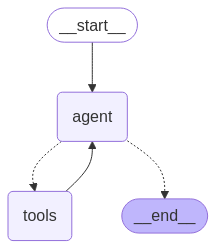

In [20]:
from IPython.display import Image, display

display(Image(agent_executor.get_graph().draw_mermaid_png()))

**IMPORTANT:** Note that we are passing in the **llm**, not **llm_with_tools**. That is because **create_react_agent** will call **.bind_tools** for us under the hood.

## **Step 4 - Execute the Agent**

In [21]:
response = agent_executor.invoke({"messages": "Hi"})

for msg in response["messages"]:
    msg.pretty_print()

================================ Human Message =================================

Hi
================================== Ai Message ==================================

Hello! How can I assist you today?


In [22]:
response = agent_executor.invoke({"messages": "What is the time?"})

for msg in response["messages"]:
    msg.pretty_print()

================================ Human Message =================================

What is the time?
================================== Ai Message ==================================
Tool Calls:
  current_datetime (call_QXXk4NyG9eV5fwuyMJ7KKv6u)
 Call ID: call_QXXk4NyG9eV5fwuyMJ7KKv6u
  Args:
================================= Tool Message =================================
Name: current_datetime

2025-03-12 16:18:47
================================== Ai Message ==================================

The current time is 16:18 (4:18 PM) on March 12, 2025.


## **Step 5 - Pretty Print**

In [23]:
def printer(input_prompt):
    for s in agent_executor.stream(input_prompt, stream_mode="values"):
        msg = s["messages"][-1]
        if isinstance(msg, tuple):
            print("tuple:", msg)
        else:
            msg.pretty_print()

In [24]:
printer(input_prompt={"messages": "hi"})

================================ Human Message =================================

hi
================================== Ai Message ==================================

Hello! How can I assist you today?


In [25]:
printer(input_prompt={"messages": "time?"})

================================ Human Message =================================

time?
================================== Ai Message ==================================
Tool Calls:
  current_datetime (call_bzIIlLfoqfZ5zK9nzZXB2rwv)
 Call ID: call_bzIIlLfoqfZ5zK9nzZXB2rwv
  Args:
================================= Tool Message =================================
Name: current_datetime

2025-03-12 16:18:52
================================== Ai Message ==================================

The current date and time is March 12, 2025, at 16:18:52.


In [26]:
printer(input_prompt={"messages": "Can you tell me the names of all the people in space?"})

================================ Human Message =================================

Can you tell me the names of all the people in space?
================================== Ai Message ==================================
Tool Calls:
  people_in_space (call_6KgplezpunGcKTDLHcGE1eZ9)
 Call ID: call_6KgplezpunGcKTDLHcGE1eZ9
  Args:
================================= Tool Message =================================
Name: people_in_space

{"people": [{"craft": "ISS", "name": "Oleg Kononenko"}, {"craft": "ISS", "name": "Nikolai Chub"}, {"craft": "ISS", "name": "Tracy Caldwell Dyson"}, {"craft": "ISS", "name": "Matthew Dominick"}, {"craft": "ISS", "name": "Michael Barratt"}, {"craft": "ISS", "name": "Jeanette Epps"}, {"craft": "ISS", "name": "Alexander Grebenkin"}, {"craft": "ISS", "name": "Butch Wilmore"}, {"craft": "ISS", "name": "Sunita Williams"}, {"craft": "Tiangong", "name": "Li Guangsu"}, {"craft": "Tiangong", "name": "Li Cong"}, {"craft": "Tiangong", "name": "Ye Guangfu"}], "number": 12, "me

In [27]:
printer(input_prompt={"messages": "Is Sunita William in space?"})

================================ Human Message =================================

Is Sunita William in space?
================================== Ai Message ==================================
Tool Calls:
  people_in_space (call_16RyE71yYiKLjUkosAWvmDG9)
 Call ID: call_16RyE71yYiKLjUkosAWvmDG9
  Args:
================================= Tool Message =================================
Name: people_in_space

{"people": [{"craft": "ISS", "name": "Oleg Kononenko"}, {"craft": "ISS", "name": "Nikolai Chub"}, {"craft": "ISS", "name": "Tracy Caldwell Dyson"}, {"craft": "ISS", "name": "Matthew Dominick"}, {"craft": "ISS", "name": "Michael Barratt"}, {"craft": "ISS", "name": "Jeanette Epps"}, {"craft": "ISS", "name": "Alexander Grebenkin"}, {"craft": "ISS", "name": "Butch Wilmore"}, {"craft": "ISS", "name": "Sunita Williams"}, {"craft": "Tiangong", "name": "Li Guangsu"}, {"craft": "Tiangong", "name": "Li Cong"}, {"craft": "Tiangong", "name": "Ye Guangfu"}], "number": 12, "message": "success"}
=======